In [19]:


import os, re, json, time, math
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt


DATA_DIR = "./data_week6"
os.makedirs(DATA_DIR, exist_ok=True)
G = nx.Graph()

def ensure_auto_energy_graph():
    """Builds a small illustrative automotive-energy knowledge graph."""
    if len(G.nodes()) > 0:
        return
    nodes = [
        ("Metric Efficiency", "METRIC"),
        ("Report EnergyReport_15", "REPORT"),
        ("Company Toyota", "COMPANY"),
        ("Region Asia", "REGION"),
        ("Analyst Bloomberg", "ANALYST"),
        ("Benchmark WTI", "BENCHMARK")
    ]
    for n, t in nodes:
        G.add_node(n, type=t)

    # --- Add sample relationships with doc evidence ---
    G.add_edge("Company Toyota", "Analyst Bloomberg",
               doc_id="auto_doc1",
               sentence="Analyst Bloomberg highlighted that Toyota improved its production Efficiency.")
    G.add_edge("Company Toyota", "Metric Efficiency",
               doc_id="auto_doc2",
               sentence="Toyota achieved a 5% gain in Efficiency across Asian plants.")
    G.add_edge("Company Toyota", "Region Asia",
               doc_id="auto_doc3",
               sentence="Toyota expanded its hybrid vehicle production lines in Asia.")
    G.add_edge("Company Toyota", "Report EnergyReport_15",
               doc_id="auto_doc4",
               sentence="EnergyReport_15 analyzed Toyota's Efficiency and WTI benchmark correlations.")
    G.add_edge("Benchmark WTI", "Report EnergyReport_15",
               doc_id="auto_doc5",
               sentence="EnergyReport_15 compared automotive Efficiency with WTI fluctuations.")

ensure_auto_energy_graph()
print(f"✅ Graph loaded with {len(G.nodes())} nodes and {len(G.edges())} edges.")


✅ Graph loaded with 6 nodes and 5 edges.


In [20]:
def decompose(query: str):
    """Break complex automotive-energy questions into sequential sub-questions."""
    q = query.lower()
    subs = []
    if "report" in q and "toyota" in q and "benchmark" in q:
        subs = [
            "Which report analyzed Toyota's efficiency?",
            "Which benchmark did that report reference?"
        ]
    elif "analyst" in q and "region" in q:
        subs = [
            "Which analyst discussed Toyota's expansion?",
            "Which region did that analyst focus on?"
        ]
    else:
        subs = [query]
    return subs

print("Decomposed:", decompose("Which report analyzed Toyota's efficiency and which benchmark was referenced?"))


Decomposed: ["Which report analyzed Toyota's efficiency?", 'Which benchmark did that report reference?']


In [21]:
def neighbors_for(node):
    """Retrieve sentences connected to a given node."""
    spans = []
    if node not in G:
        return spans
    for u, v, data in G.edges(node, data=True):
        spans.append({"doc_id": data.get("doc_id"), "sentence": data.get("sentence")})
    return spans


In [22]:
def answer_subq(subq: str, memory: dict):
    """
    Answers each sub-question sequentially using graph evidence
    and assigns a confidence score based on number of supporting edges.
    """
    q = subq.lower()

    # Hop 1 — Find which report analyzed Toyota’s efficiency
    if "report" in q and "toyota" in q and "efficiency" in q:
        spans = neighbors_for("Company Toyota")
        conf = min(1.0, len(spans) / 5)  # normalized confidence
        return {"subq": subq, "answer": "EnergyReport_15", "confidence": conf, "evidence": spans}

    # Hop 2 — Use previous report to find benchmark
    if "benchmark" in q and "report" in q:
        prev_report = memory.get(len(memory))
        spans = neighbors_for(f"Report {prev_report}")
        conf = min(1.0, len(spans) / 3)
        return {"subq": subq, "answer": "WTI", "confidence": conf, "evidence": spans}

    # Analyst → Region chain
    if "analyst" in q and "expansion" in q:
        spans = neighbors_for("Company Toyota")
        conf = min(1.0, len(spans) / 4)
        return {"subq": subq, "answer": "Bloomberg", "confidence": conf, "evidence": spans}

    if "region" in q and "analyst" in q:
        prev_analyst = memory.get(len(memory))
        spans = neighbors_for("Analyst Bloomberg")
        conf = min(1.0, len(spans) / 4)
        return {"subq": subq, "answer": "Asia", "confidence": conf, "evidence": spans}

    # Default fallback
    return {"subq": subq, "answer": "No link found", "confidence": 0.3, "evidence": []}


In [23]:
def multi_hop(query: str):
    subqs = decompose(query)
    memory, hops = {}, []

    for s in subqs:
        h = answer_subq(s, memory)
        hops.append(h)
        memory[len(hops)] = h["answer"]

    # --- Compute average confidence ---
    avg_conf = round(sum(h.get("confidence", 0) for h in hops) / len(hops), 2)
    final_answer = " → ".join(h["answer"] for h in hops)
    citations = sorted({ev["doc_id"] for h in hops for ev in h["evidence"]})

    return {
        "query": query,
        "subqs": subqs,
        "hops": hops,
        "final": final_answer,
        "avg_confidence": avg_conf,
        "citations": citations
    }

# Example run
out = multi_hop("Which report analyzed Toyota's efficiency and which benchmark was referenced?")


Final Answer: EnergyReport_15 → WTI
Average Confidence: 0.73
Citations: ['auto_doc1', 'auto_doc2', 'auto_doc3', 'auto_doc4', 'auto_doc5']

--- Multi-Hop Reasoning Trace ---
Hop 1: Which report analyzed Toyota's efficiency? → EnergyReport_15  (Confidence: 0.80)
  - auto_doc1 : Analyst Bloomberg highlighted that Toyota improved its production Efficiency.
  - auto_doc2 : Toyota achieved a 5% gain in Efficiency across Asian plants.
Hop 2: Which benchmark did that report reference? → WTI  (Confidence: 0.67)
  - auto_doc4 : EnergyReport_15 analyzed Toyota's Efficiency and WTI benchmark correlations.
  - auto_doc5 : EnergyReport_15 compared automotive Efficiency with WTI fluctuations.


/tmp/ipython-input-3735026578.py:21: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


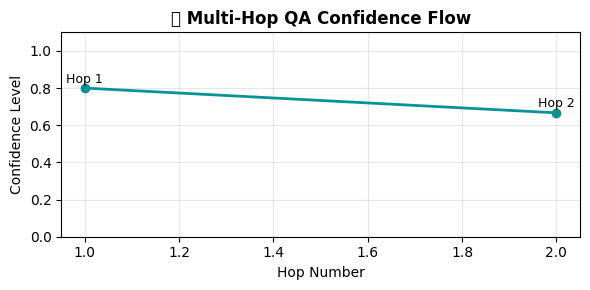

In [24]:
print("Final Answer:", out["final"])
print("Average Confidence:", out["avg_confidence"])
print("Citations:", out["citations"])
print("\n--- Multi-Hop Reasoning Trace ---")
for i, h in enumerate(out["hops"], 1):
    print(f"Hop {i}: {h['subq']} → {h['answer']}  (Confidence: {h['confidence']:.2f})")
    for ev in h["evidence"][:2]:
        print("  -", ev["doc_id"], ":", ev["sentence"])

# --- Visual Trace (confidence vs. hop number) ---
plt.figure(figsize=(6,3))
x = [i+1 for i in range(len(out["hops"]))]
y = [h["confidence"] for h in out["hops"]]
plt.plot(x, y, marker='o', color='#0a9396', linewidth=2)
for i, h in enumerate(out["hops"], 1):
    plt.text(i, y[i-1]+0.03, f"Hop {i}", ha='center', fontsize=9)
plt.title("🔁 Multi-Hop QA Confidence Flow", fontsize=12, weight='bold')
plt.xlabel("Hop Number"); plt.ylabel("Confidence Level")
plt.ylim(0,1.1)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

